[Notebook Organization &lt;](4_Organization.ipynb) | [&gt; Package Use](6_Packages.ipynb)

# Collaboration

I define a collaborative repository as one that has at least one fork or issue. A watched repository is not collaborative, but has at least one watcher or stargazer. An isolated repository is neither collaborative nor watched.

## Results Summary:
- Collaboration status
    - 17.51% of repositories are collaborative (23.43% of notebooks).
    - 41.28% are watched (40.62% of notebooks).
    - 41.21% are isolated (35.96% of notebooks).

- On average, a collaborative repository has 11.76 forks  (median = 1.0) and 1.98 issues (median = 0.0).
- Markdown to Code ratio versus collaboration status
    - Among collaborative notebooks, the average markdown to code ratio is 0.77.
    - Among watched notebooks, the average markdown to code ratio is 0.684.
    - Among isolated notebooks, the average markdown to code ratio is 0.631.
- Isolated repositories are less likely to have repository descriptions. We are 95% confident that the true proportion of isolated repositories with a description is between 0.097 and 0.101 lower than that for not isolated repositories.
- Collaborative repositories tend to be the largest, followed by watched and isolated.
- Educational repositories are slightly more likely to be watched than they are to be collaborative or isolated.


------------

# Import Packages & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
import load_data
import scipy.stats as st


Load dataframes.

In [2]:
notebooks = load_data.load_notebooks()
repos = load_data.load_repos()

Notebooks loaded in 0:00:25.002068
Repos loaded in 0:00:04.342632


Load aggregations. Code for cell types can be found in [Organization.ipynb](Organization.ipynb) and code for educational statuses can be found in [Owners.ipynb](Owners.ipynb).

In [3]:
cell_types_df = load_data.load_cell_types()
cell_stats_df = load_data.load_cell_stats()
edu_statuses_df = load_data.load_edu_status()

Cell types loaded in 0:00:01.869774
Cell stats loaded in 0:00:01.872590
Educational status loaded in 0:00:00.002882


In [4]:
cell_stats_df['words_lines_ratio'] = [row['num_words']/row['lines_of_code'] if row['lines_of_code'] != 0 else np.nan for _, row in cell_stats_df.iterrows()]

---
# Manipulate Data

### What is the collaboration status of a notebook?
- Collaborative: if there are forks or open issues
- Watched: if there are stargazers or subscribers *and* is not collaborative
- Isolated: if neither collaborative nor watched

In [5]:
collaborative = repos[np.logical_or(
    repos['forks_count'] > 0,
    repos['open_issues_count'] > 0
)]

watched = repos[np.logical_and(
    np.logical_or(
        repos['stargazers_count'] > 0,
        repos['subscribers_count'] > 0
    ),
    ~repos.repo_id.isin(collaborative.repo_id)
)]

collab_or_watched = pd.concat([collaborative, watched])

isolated = repos[~np.logical_or(
    repos.repo_id.isin(collaborative.repo_id),
    repos.repo_id.isin(watched.repo_id)
)]

In [6]:
collab_status_df = pd.DataFrame({
    'repo_id': list(collaborative.repo_id) + list(watched.repo_id) + list(isolated.repo_id),
    'collab': ['collaborative']*len(collaborative) + ['watched']*len(watched) + ['isolated']*len(isolated)
})

In [7]:
f = open('analysis_data/collab_status.df','wb')
pickle.dump(collab_status_df, f)
f.close()

---
# Visualizations & Statistics

## Collaboration Status

In [8]:
print("{0}% of repositories are collaborative.".format(
    round(100*len(collaborative)/len(repos), 2)
))
print("{0}% are watched.".format(
    round(100*len(watched)/len(repos), 2)
))
print("{0}% are isolated.".format(
    round(100*len(isolated)/len(repos), 2)
))

17.51% of repositories are collaborative.
41.28% are watched.
41.21% are isolated.


In [9]:
print("""On average, a collaborative repository has {0} forks 
(median = {1}) and {2} issues (median = {3}). 
The most forks a repository has is {4}, at {5}.
The most issues a repository has is {6}, at {7}.""".format(
    round(collaborative.forks_count.mean(), 2),
    collaborative.forks_count.median(),
    round(collaborative.open_issues_count.mean(), 2),
    collaborative.open_issues_count.median(),
    collaborative.forks_count.max(),
    collaborative[collaborative.forks_count == collaborative.forks_count.max()].repo_html_url.values[0],
    collaborative.open_issues_count.max(),
    collaborative[collaborative.open_issues_count == collaborative.open_issues_count.max()].repo_html_url.values[0]
))

On average, a collaborative repository has 11.76 forks 
(median = 1.0) and 1.98 issues (median = 0.0). 
The most forks a repository has is 76088, at https://github.com/tensorflow/tensorflow.
The most issues a repository has is 7260, at https://github.com/vz-risk/VCDB.


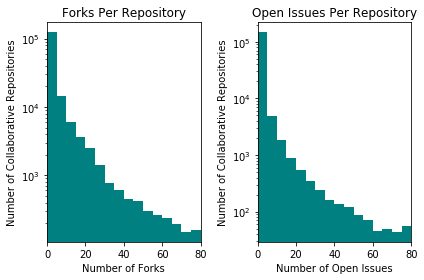

In [10]:
plt.subplot(1,2,1)
plt.hist(collaborative.forks_count, bins = range(0,85,5), color = 'teal')
plt.xlim(0, 80)
plt.title('Forks Per Repository')
plt.xlabel('Number of Forks')
plt.ylabel('Number of Collaborative Repositories')
plt.yscale('log')

plt.subplot(1,2,2)
plt.hist(collaborative.open_issues_count, bins = range(0,85,5), color = 'teal')
plt.xlim(0, 80)
plt.title('Open Issues Per Repository')
plt.xlabel('Number of Open Issues')
plt.ylabel('Number of Collaborative Repositories')
plt.yscale('log')

plt.tight_layout()
plt.show()

## Does amount of markdown depend on collaboration status

In [11]:
collaborative_wl = collaborative.merge(notebooks[['file','repo_id']], on = 'repo_id').merge(
    cell_stats_df[['file','words_lines_ratio']], on = 'file')
collaborative_wl['type'] = 'collaborative'
collaborative_wl = collaborative_wl[~collaborative_wl.words_lines_ratio.isna()]

watched_wl = watched.merge(notebooks[['file','repo_id']], on = 'repo_id').merge(
    cell_stats_df[['file','words_lines_ratio']], on = 'file')
watched_wl['type'] = 'in_sight'
watched_wl = watched_wl[~watched_wl.words_lines_ratio.isna()]

isolated_wl = isolated.merge(notebooks[['file','repo_id']], on = 'repo_id').merge(
    cell_stats_df[['file','words_lines_ratio']], on = 'file')
isolated_wl['type'] = 'isolated'
isolated_wl = isolated_wl[~isolated_wl.words_lines_ratio.isna()]

print("Among collaborative notebooks, the average words markdown to lines code ratio is {0} (median = {1}).".format(
    round(collaborative_wl.words_lines_ratio.mean(), 3),
    round(collaborative_wl.words_lines_ratio.median())
))
print("Among watched notebooks, the average words markdown to lines code ratio is {0} (median = {1}).".format(
    round(watched_wl.words_lines_ratio.mean(), 3),
    round(watched_wl.words_lines_ratio.median())
))
print("Among isolated notebooks, the average words markdown to lines code ratio is {0} (median = {1}).".format(
    round(isolated_wl.words_lines_ratio.mean(), 3),
    round(isolated_wl.words_lines_ratio.median())
))

Among collaborative notebooks, the average words markdown to lines code ratio is 8.215 (median = 1).
Among watched notebooks, the average words markdown to lines code ratio is 6.335 (median = 1).
Among isolated notebooks, the average words markdown to lines code ratio is 5.709 (median = 1).


#### One way anova for difference in mean markdown to code ratio between collaborative, watched, and isolated notebooks

$H_0: \mu_{collaborative} =  \mu_{watched} = \mu_{isolated}$

$H_a$: at least one is not equal

In [12]:
F, p = st.f_oneway(
    collaborative_wl.words_lines_ratio, 
    watched_wl.words_lines_ratio, 
    isolated_wl.words_lines_ratio
)
print("F-statistic = {0}, p-value = {1}".format(
    round(F, 2), round(p, 2)
))

F-statistic = 688.02, p-value = 0.0


#### Non-parametric one way anova on ranks (Kruskal-Wallis) for difference in means
The data is extremely skewed right, so a parametric test that relies on normality may not be the best option. Check if the non-parametric Kruskal-Wallis test gives the same results.

In [13]:
H, p = st.kruskal(
    collaborative_wl.words_lines_ratio, 
    watched_wl.words_lines_ratio, 
    isolated_wl.words_lines_ratio
)
print("Kruskal Wallis H-statistic = {0}, p-value = {1}".format(
    round(H, 2), round(p, 2)
))

Kruskal Wallis H-statistic = 9799.82, p-value = 0.0


#### Pairwise two sample t-tests for difference in means

In [14]:
t1, p1 = st.mstats.ttest_ind(
    collaborative_wl.words_lines_ratio, 
    watched_wl.words_lines_ratio
)
t2, p2 = st.mstats.ttest_ind(
    watched_wl.words_lines_ratio, 
    isolated_wl.words_lines_ratio
)
t3, p3 = st.mstats.ttest_ind(
    collaborative_wl.words_lines_ratio, 
    isolated_wl.words_lines_ratio
)
print('Pairwise p-values are all zero, so all significant: {0}, {1}, {2}.'.format(
    round(p1,2), round(p2,2), round(p3,2)
))

Pairwise p-values are all zero, so all significant: 0.0, 0.0, 0.0.


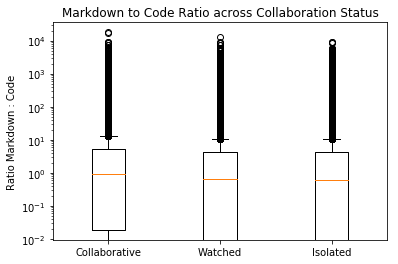

In [15]:
data = [
    collaborative_wl.words_lines_ratio, 
    watched_wl.words_lines_ratio, 
    isolated_wl.words_lines_ratio
]
fig, ax = plt.subplots()
ax.boxplot(data)
plt.yscale('log')
plt.ylabel('Ratio Markdown : Code')
plt.xticks([1,2,3],['Collaborative','Watched','Isolated'])
plt.title('Markdown to Code Ratio across Collaboration Status')

plt.show()

We've concluded that collaborative notebooks have the largest markdown to code ratio, followed by watched and then isolated notebooks. All differences are significant.

## Are isolated repositories more or less likely to have descriptions?
It makes sense that respoitories no one looks at may not have a repository description. Here we focus only on isolated repositories versus not-isolated repositories.

In [16]:
print(
    "{0}% of repositories that are collaborative or watched have a repository description.".format(
        round(100 - 100*sum(collab_or_watched.repo_description.isna())/len(collab_or_watched), 2)
))

print(
    "{0}% of repositories that are isolated have a repository description.".format(
        round(100 - 100*sum(isolated.repo_description.isna())/len(isolated), 2)
))

58.21% of repositories that are collaborative or watched have a repository description.
48.31% of repositories that are isolated have a repository description.


#### Two sample z test for difference in proportion of repositories with descriptions between isolated repositories and non-isolated respositories

$H_0: p_{isolated} = p_{not\_isolated}$, the true proportion of all isolated repositories with a description is equal to that of not isolated repositories

$H_a: p_{isolated} ≠ p_{not\_isolated}$, the true proportions are not equal

In [17]:
p1 = 1-sum(collab_or_watched.repo_description.isna())/len(collab_or_watched)
n1 = len(collab_or_watched)

p2 = 1-sum(isolated.repo_description.isna())/len(isolated)
n2 = len(isolated)

ppool = (p1*n1 + p2*n2)/(n1 + n2)
se = (ppool*(1-ppool)*(1/n1 + 1/n2))**0.5
z = (p1 - p2)/se
p_value = 1 - st.norm.cdf(z)

print('z-statistic:', round(z, 2))
print('p-value:', round(p_value, 2))

z-statistic: 92.67
p-value: 0.0


At any reasonable singificance level, the z statistic of 68.37 provides strong evidence to conclude that the true proportion of isolated repositories with a description is not equal to that of not isolated repositories.

In [18]:
z_star = st.norm.ppf(0.975)
lower = (p1 - p2) - z_star*se
upper = (p1 - p2) + z_star*se

print("""We are 95% confident that the true proportion of isolated 
repositories with a description is between {0} and {1} lower 
than that for not isolated repositories.""".format(
    round(lower, 3), round(upper, 3)
))

We are 95% confident that the true proportion of isolated 
repositories with a description is between 0.097 and 0.101 lower 
than that for not isolated repositories.


## Does repository size depend on collaboration status

In [19]:
print("On average, collaborative repositories are {0} bytes (median = {1}).".format(
    round(collaborative['size'].mean(), 2),
    round(collaborative['size'].median())
))
print("On average, watched repositories are {0} bytes (median = {1}).".format(
    round(watched['size'].mean(), 2),
    round(watched['size'].median())
))
print("On average, isolated repositories are {0} bytes (median = {1}).".format(
    round(isolated['size'].mean(), 2),
    round(isolated['size'].median())
))

On average, collaborative repositories are 40450.31 bytes (median = 2811).
On average, watched repositories are 24809.85 bytes (median = 1132).
On average, isolated repositories are 15785.87 bytes (median = 583).


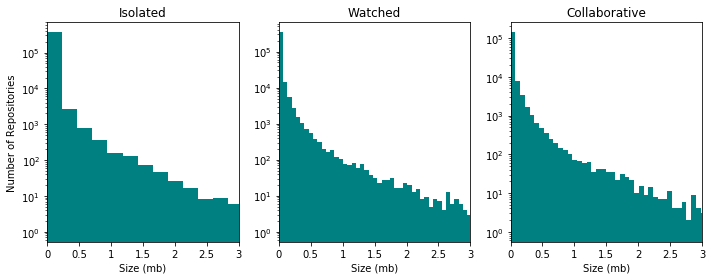

In [20]:
fig = plt.figure(figsize=(10, 4))

plt.subplot(1,3,1)
plt.hist(isolated['size'], bins = 100, color = 'teal')
plt.title('Isolated')
plt.xlabel('Size (mb)')
plt.xlim(0, 300000)
x_pos = [0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000]
x_labs = [0, .5, 1, 1.5, 2, 2.5, 3]
plt.xticks(x_pos, x_labs)
plt.ylabel('Number of Repositories')
plt.yscale('log')

plt.subplot(1,3,2)
plt.hist(watched['size'], bins = 500, color = 'teal')
plt.title('Watched')
plt.xlabel('Size (mb)')
plt.xlim(0, 300000)
x_pos = [0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000]
x_labs = [0, .5, 1, 1.5, 2, 2.5, 3]
plt.xticks(x_pos, x_labs)
plt.yscale('log')

plt.subplot(1,3,3)
plt.hist(collaborative['size'], bins =500, color = 'teal')
plt.title('Collaborative')
plt.xlabel('Size (mb)')
plt.xlim(0, 300000)
x_pos = [0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000]
x_labs = [0, .5, 1, 1.5, 2, 2.5, 3]
plt.xticks(x_pos, x_labs)
plt.yscale('log')

plt.tight_layout()
plt.show()

## Does collaboration status depend on educational status?

In [21]:
edu_collab_df = collab_status_df.merge(edu_statuses_df, on = 'repo_id')

In [22]:
contingency = (edu_collab_df.groupby(
    ['collab','edu']
)['repo_id'].count()).reset_index().pivot(
    index = 'collab', columns = 'edu', values = 'repo_id'
)
contingency

edu,False,True
collab,,
collaborative,78224,21451
isolated,138028,40779
watched,156435,51236


#### Chi squared test for independence of collaboration status and educational status

In [23]:
chi2, p, dof, ex = st.chi2_contingency(contingency)
print('Chi Squared = {0}, p-value = {1}'.format(
    round(chi2, 2), round(p, 2)
))

Chi Squared = 418.66, p-value = 0.0


Collaboration status and educational are associated.

In [24]:
conditional_props = (contingency[True]/(contingency[True] + contingency[False]))
print("Probability of a notebook being educational given that it is collaborative = {0}.".format(
    round(conditional_props['collaborative'], 3)
))
print("Probability of a notebook being educational given that it is watched = {0}.".format(
    round(conditional_props['watched'], 3)
))
print("Probability of a notebook being educational given that it is isolated = {0}.".format(
    round(conditional_props['isolated'], 3)
))

print("\nDifference between observed and expected")
contingency - ex

Probability of a notebook being educational given that it is collaborative = 0.215.
Probability of a notebook being educational given that it is watched = 0.247.
Probability of a notebook being educational given that it is isolated = 0.228.

Difference between observed and expected


edu,False,True
collab,,
collaborative,1812.712350,-1812.712350
isolated,953.777669,-953.777669
watched,-2766.490019,2766.490019


Collaborative and isolated repositories are more likely to be non-educational than would be expected if the variables were not related. Watched repositories are more likely to be educational.

## Look at notebook statuses

In [25]:
collaborative_nbs = notebooks[notebooks.repo_id.isin(collaborative.repo_id)]
watched_nbs = notebooks[notebooks.repo_id.isin(watched.repo_id)]
isolated_nbs = notebooks[notebooks.repo_id.isin(isolated.repo_id)]

In [26]:
total = len(collaborative_nbs) + len(watched_nbs) + len(isolated_nbs)
print("""{0}% of notebooks are in collaborative repositories. 
{1}% are in 'watched' repositories.
Finally {2}% of notebooks are in isolated repositories""".format(
    round(100*len(collaborative_nbs)/total, 2),
    round(100*len(watched_nbs)/total, 2),
    round(100*len(isolated_nbs)/total, 2),
))

23.4% of notebooks are in collaborative repositories. 
40.53% are in 'watched' repositories.
Finally 36.07% of notebooks are in isolated repositories


[Notebook Organization &lt;](4_Organization.ipynb) | [&gt; Package Use](6_Packages.ipynb)